In [2]:
import sys
sys.path.insert(0, '../../')
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

In [3]:
import sys
from torch.utils.data import DataLoader, Dataset, TensorDataset
from data .Modelnet10toSet import *
from data .pointcloud_utils import *
import matplotlib.pyplot as plt
import random

In [ ]:
!pwd

In [ ]:
%cd ..
%cd ..
%cd visualisation

In [21]:
train_data = PointCloudData()
test_data = PointCloudData(None, Train=False, folder='test', transform=None)
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
test_loader = DataLoader(test_data, batch_size=32,shuffle=True)

In [22]:
dataset = PointCloudData()
class_names =   [ 'bathtub' , 'bed' , 'chair',  'desk' , 'dresser' , 'monitor' , 'night_stand' , 'sofa' ,  'table' ,  'toilet']
sampleSet = []
for i in range(0,len(class_names)):
    for j in range(0,len(dataset)):
        if i == dataset[j]['category']:
            sampleSet.append(dataset[j]['pointcloud'])
            break

In [23]:
set_channels = 3
set_size = 2048
  
hidden_dim = 128
iters = 10
latent_dim = 64
lr = 0.001
n_epochs = 50
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [24]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [29]:
!pwd

/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/visualisation


In [36]:
model = torch.load('../Tutorials/DeepSets  PointCloud/FSEncoder_model_modelnet10.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [37]:
miNet.load_state_dict(torch.load('../Tutorials/DeepSets  PointCloud/FSEncoder_model_modelnet10.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [38]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

Tamaño del dataset:  3991
Numero de elementos por muestra:  3 que se corresponde con la etiqueta, el conjunto de puntos y la mascara
Tamaño del conjunto de puntos:  (3, 2048)
Representación del conjunto de puntos: 


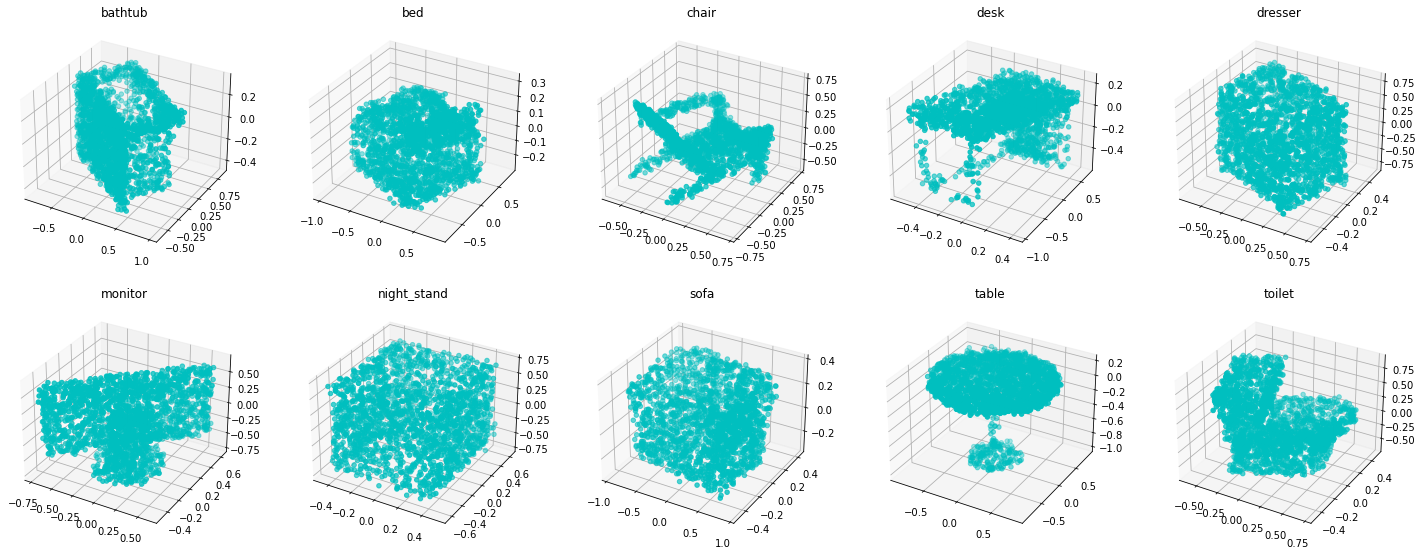

In [39]:
print('Tamaño del dataset: ',len(dataset))
print('Numero de elementos por muestra: ',len(dataset[0]),'que se corresponde con la etiqueta, el conjunto de puntos y la mascara')
print('Tamaño del conjunto de puntos: ',dataset[0]['pointcloud'].numpy().shape)
print('Representación del conjunto de puntos: ')
fig = plt.figure(figsize=(25, 25))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = sampleSet[i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c',marker='o',s=20)
    plt.title(class_names[i])
    # ==============

In [ ]:
miNet = miNet
miNet.eval()
losses = []
accs = []
device = 'cpu'
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        label = sample['category']
        target_set = sample['pointcloud']
        target_mask = sample['mask']
        output = miNet(target_set.to(device),target_mask.to(device))
        loss = F.cross_entropy(output.to(device), label.to(device))
        acc = (output.max(dim=1)[1].to(device) == label.to(device)).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0:  72%|█████████▍   | 21/29 [01:05<00:28,  3.58s/batch, acc=84.4, loss=0.366]

In [ ]:
for name, param in miNet.named_parameters():
    print(name, param.size())

In [ ]:
model.classifier = nn.Sequential(*[miNet.conv[i] for i in range(3)])
print(model.classifier)

In [ ]:
get_weight(miNet)

In [ ]:
with torch.no_grad():
    sampleMask = torch.ones(2048)
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility".format(np.argmax(pred).item(),class_names[i]))

In [ ]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-2]))
print(model1)

In [ ]:
with torch.no_grad():
    pred = model1(sampleSet[0].unsqueeze(0))
print(pred.shape)

In [ ]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[8].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [ ]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    critical_points_z = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
        critical_points_z.append(points[2,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    z = np.array(critical_points_z)
    s = np.stack((y,x,z))
    
    return s 

In [ ]:
def no_critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    critical_points_z = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmin(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
        critical_points_z.append(points[2,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    z = np.array(critical_points_z)
    s = np.stack((y,x,z))
    
    return s 

In [ ]:
crit = dataset[800]['pointcloud']
s = critical_points_MaxEncoder(model1,crit)
s.shape

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = sampleSet[i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c',marker='o',s=20)
    surf2 = ax.scatter(crit[0,:], crit[1,:], crit[2, :],color='r',marker='o',s=20)
    plt.title(class_names[i])
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
a = sampleSet[3].numpy()
crit = critical_points_MaxEncoder(model1,sampleSet[3])
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=a[0], y=a[1], z=a[2],
                                   marker=dict(size=5,
                      line=dict(width=1,
                      color='navy')),
                                   mode='markers'))
fig.add_trace(go.Scatter3d(x=crit[0], y=crit[1], z=crit[2],
                                  marker=dict(size=5,
                      line=dict(width=3,
                      color='#d62728')),
                                   mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
dataset = PointCloudData()
for i,j in enumerate(dataset.files):
    if list(j.values())[0] == '../data/10/raw/chair/train/chair_0009.off':
        s = (dataset[i]['pointcloud'])
        l = (dataset[i]['category'])
        m = (dataset[i]['mask'])
        break
s

In [ ]:
import plotly.graph_objects as go
import numpy as np
a = s.numpy()
crit = critical_points_MaxEncoder(model1,s)
no_crit = no_critical_points_MaxEncoder(model1,s)
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=a[0], y=a[1], z=a[2],
                                   marker=dict(size=5,
                      line=dict(width=1,
                      color='blue')),
                                   mode='markers'))
fig.add_trace(go.Scatter3d(x=crit[0], y=crit[1], z=crit[2],
                                  marker=dict(size=6,
                      line=dict(width=3,
                      color='#d62728')),
                                   mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(
    scene = dict(
        xaxis = dict(visible = False,),
                     yaxis = dict(visible = False,),
                     zaxis = dict(visible = False,),),)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
def plotting_crit(s):
    a = s.numpy()
    crit = critical_points_MaxEncoder(model1,s)
    no_crit = no_critical_points_MaxEncoder(model1,s)
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(x=a[0], y=a[1], z=a[2],
                                       marker=dict(size=5,
                          line=dict(width=1,
                          color='blue')),
                                       mode='markers'))
    fig.add_trace(go.Scatter3d(x=crit[0], y=crit[1], z=crit[2],
                                      marker=dict(size=6,
                          line=dict(width=3,
                          color='#d62728')),
                                       mode='markers'))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible = False,),
                         yaxis = dict(visible = False,),
                         zaxis = dict(visible = False,),),)

    fig.show()

In [ ]:
plotting_crit(s)

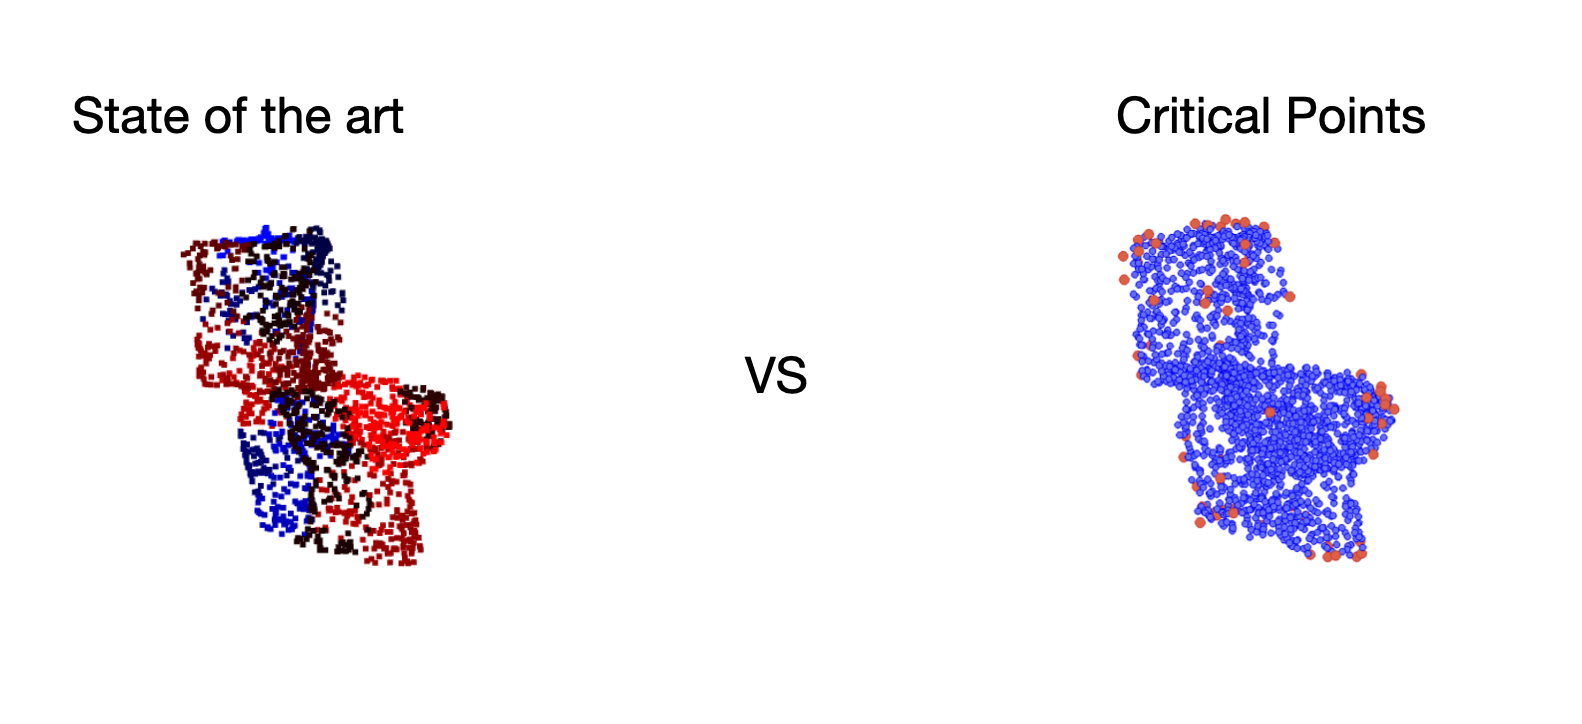